In [1]:
from chemotaxis import Chemotaxis
import numpy as np
%load_ext autoreload

## Model

Given the assumptions and the model in the assignment sheet:

$\lambda (s) = \frac{A_{max} - A_{min}}{1 + exp(ks)} + A_{min}$ and $\tau_s \dot{s} = -s+\Delta c$

Using simple Euler integration to approach this: $s_{n+1} = s_n + dt \dot{s} = s_n + dt\frac{-s_n + \Delta c(x_n, x_{n-1})}{\tau_s}$ where $\Delta c$ is a function of current and prvious cell position. 

Initialise the coeficient and parameters we are going to use in the simulation, and because we are running the simulation in discrete spatial and temporal space:
- velocity takes one unit position step in one unit time step.
- the fixed timestep is 1 unit.
- the initial direction of the cell is positive, once tumble happens this is changed to -1
- initial position of the cell is 0
- initial value of s in the Euler integration is set to 0 (need justification, what is the physical meaning of s?)
- $A_{max}$ and $k$ are set to 0.75 and 1 respectively for reasons we will see later.

In [2]:
parameters = {'velocity' : 1, 'dt' : 1, 'direction' : 1, 'x' : 0, 's' : 0, 'maxA' : 0.75, 'k' : 1}

The choice of $A_{max}$ and $k$ can be justified in supplementary ipy notebook 1 where the function $\lambda(s)$ is plotted with two adjustable slide bar for $A_{max}$ and $k$. It is directly visual that this function is a modified sigmoid function (very close form to a logistic function). The $A_{max}$ controls the maximum saturation and $k$ controls the steepness. We can also see what $A_{min}$ means (mininum saturation) but we will examine its influence in the simulation instead.

## Flat Concentration Distribution

In [3]:
parameters['cType'] = "flat"

In [4]:
exp1 = Chemotaxis(**parameters)

Firstly let us plot 10 simulation of flat concentration for 1000 steps. The parameters are set to $A_{min} = 0.5$ and $\tau_s = 1$

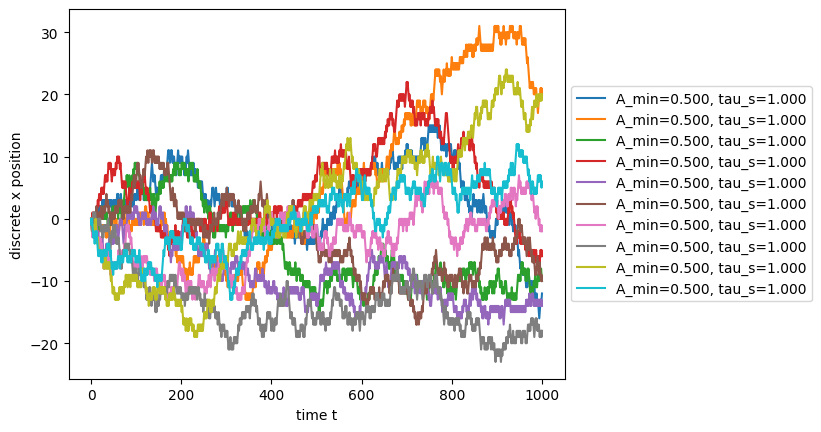

In [20]:
%autoreload
N = 10
A_min = [0.5] * N
tau_s = [1] * N
exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

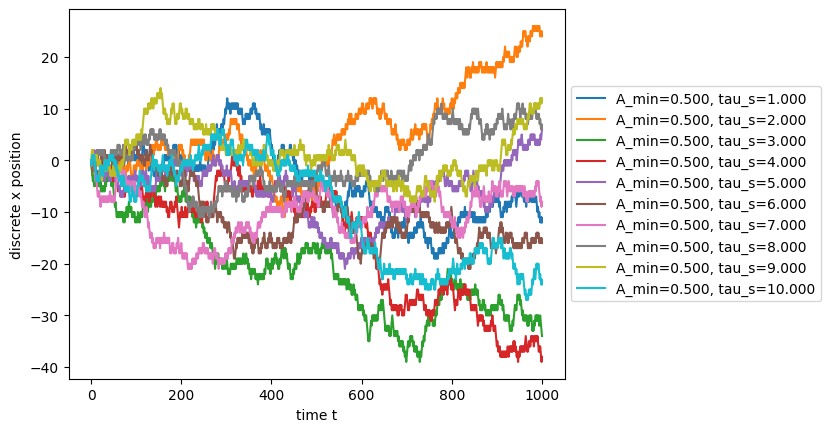

In [19]:
%autoreload
N = 10
A_min = [0.5] * N
tau_s = [i for i in np.linspace(1, 10, N)]
exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

We can see that $\tau_s$ plays no significant role when the concentration gradient is zero. In fact by inspecting the formula above, if s is initialised to be 0, then s will remain 0 throughout the simulation. And if s is set to a non-zero value, it will still gradually converge to zero $s_{n+1} = s_n(1 - 1/\tau_s)$, the convergence rate of which will depend on $\tau_s$ (larger value gives slower convergence).

[10, 9.0, 8.1, 7.29, 6.561, 5.9049, 5.31441, 4.782969, 4.3046720999999994, 3.8742048899999997, 3.4867844009999995, 3.1381059608999995, 2.8242953648099993, 2.541865828328999, 2.2876792454960992, 2.058911320946489, 1.8530201888518403, 1.6677181699666563, 1.5009463529699907, 1.3508517176729917, 1.2157665459056926, 1.0941898913151233, 0.984770902183611, 0.8862938119652499, 0.797664430768725, 0.7178979876918524, 0.6461081889226672, 0.5814973700304005, 0.5233476330273604, 0.47101286972462436, 0.4239115827521619, 0.38152042447694573, 0.34336838202925113, 0.309031543826326, 0.27812838944369345, 0.2503155504993241, 0.22528399544939168, 0.20275559590445252, 0.18248003631400728, 0.16423203268260655, 0.1478088294143459, 0.1330279464729113, 0.11972515182562017, 0.10775263664305815, 0.09697737297875234, 0.0872796356808771, 0.07855167211278939, 0.07069650490151046, 0.06362685441135942, 0.057264168970223475, 0.051537752073201125]
[10, 5.0, 2.5, 1.25, 0.625, 0.3125, 0.15625, 0.078125, 0.0390625, 0.0195

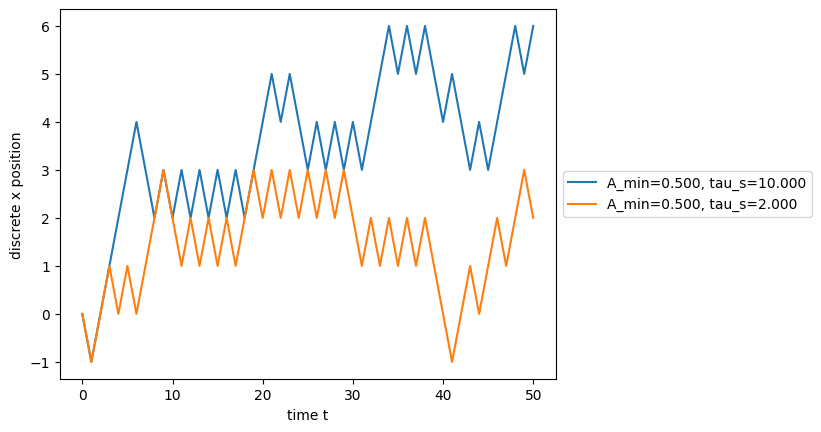

In [21]:
%autoreload
parameters['s'] = 10
exp1_1 = Chemotaxis(**parameters)
exp1_1.run_simulation(0.5, 10, no_steps=50)
print(exp1_1.s_list)
exp1_1.run_simulation(0.5, 2, no_steps=50)
print(exp1_1.s_list)

From the above arguments, we can deduce that one of the possible intepretations of $\tau_s$ is how fast the cell detects the change in the environment, when it is set to 1, $s_{n+1}$ will just be $\Delta c$ at step n. The role of s is also hinted in this explaination - it is the signal sensing by the cell. This means s is responding to concentration gradient with a time constance. As we saw earlier in the supplementary notebook 1

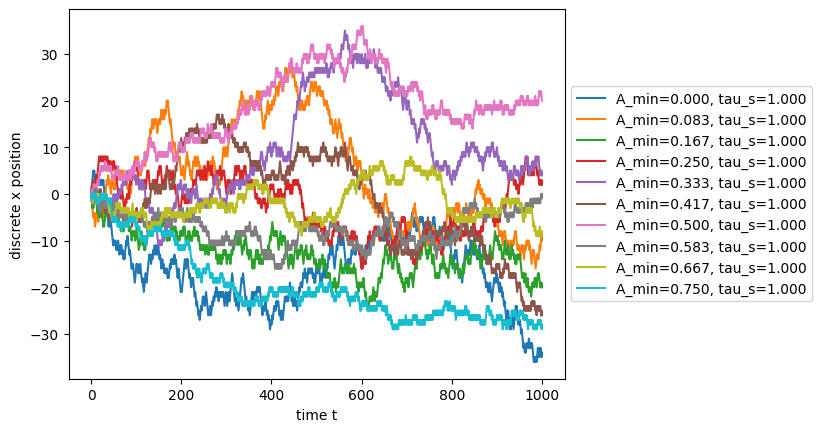

In [22]:
%autoreload
N = 10
A_min = [i for i in np.linspace(0, 0.75, N)]
tau_s = [1] * N
exp1.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

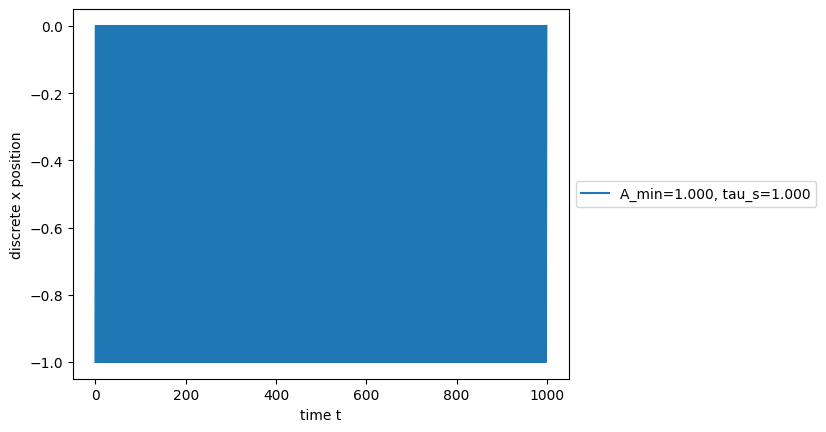

In [6]:
%autoreload
# if A_min = A_max
exp1.run_simulation(1, 1, no_steps=1000)

This is because the probability of tumbling (reverse direction) is 1 throughout the simulation.

In [7]:
print(f"Throughout the simulation there are {len(exp1.tumble_ps)} recorded tumble probability values")
print(f"The maximum value is {max(exp1.tumble_ps)}")
print(f"The minimum value is {min(exp1.tumble_ps)}")

Throughout the simulation there are 1000 recorded tumble probability values
The maximum value is 1.0
The minimum value is 1.0


## Linear Concentration Distribution

In [8]:
exp2 = Chemotaxis(velocity=1, dt=1, direction=1, x=0, s=0, maxA=1, k=1, cType="linear")

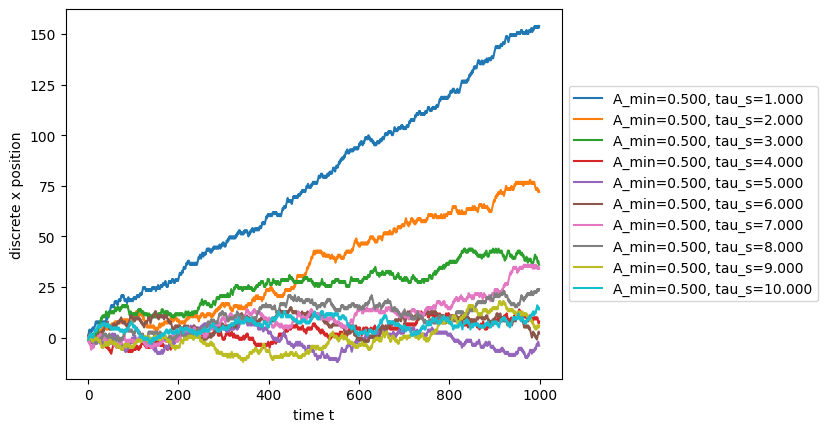

In [9]:
%autoreload
N = 10
A_min = [0.5] * N
tau_s = [i for i in np.linspace(1, 10, N)]
exp2.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

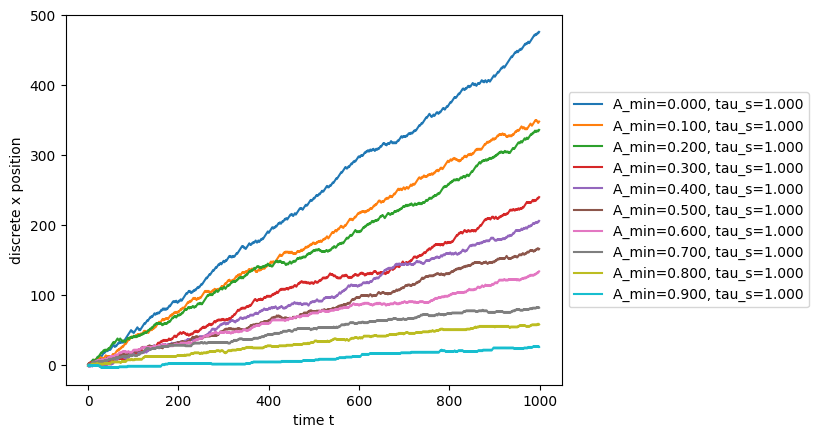

In [10]:
%autoreload
N = 10
A_min = [i for i in np.linspace(0, 0.9, N)]
tau_s = [1] * N
exp2.plt_multiple_traj(N, A_min, tau_s, no_steps=1000)

[0.75, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.8655292893150024, 0.6344707106849976, 0.6344707106849976, 0.6344707106849976, 0.86552928931

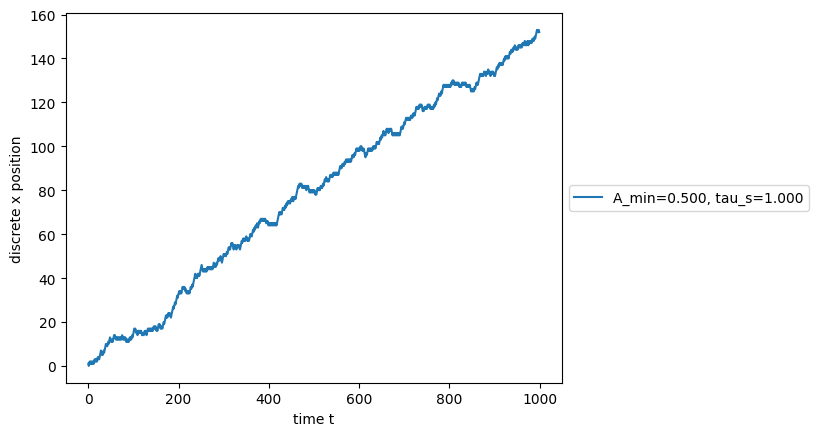

In [15]:
%autoreload
# if A_min = 0
exp2.run_simulation(0.5, 1, no_steps=1000)
print(exp2.tumble_ps)
print(exp2.s_list)